# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.


# Laboratory 2 - PyTorch, Convolution and Correlation, Filtering, Simple Neural Networks

The goal of the Laboratory 2 is to:
<ul>
  <li> Familiarize yourself with basic PyTorch functionalities.
  <li> Understand and implement 2-D correlation / convolution functions.
  <li> Undersand the differences between CPU and GPU execution.
  <li> Learn how to implement simple neural network architectures in PyTorch.
</ul>

For simplicity, during this laboratory we are not going to use any medical dataset.

### Part I - Convolution and Correlation

The first task is to understand the convolution and correlation operators.

Let's start from defining 2-D arrays and apply the built-in convolution/correlation function available in SciPy for NumPy arrays:

In [87]:
import torch
import numpy as np
import scipy.ndimage as nd
import torch as tc
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import torch.nn as nn
from torchsummary import summary



In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
input = np.array([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
])

filter = np.array([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
])

convolution_result = nd.convolve(input, filter, mode="constant")
correlation_result = nd.correlate(input, filter, mode="constant")

print("Convolution result: ")
print(convolution_result)
print("Correlation result: ")
print(correlation_result)


Convolution result: 
[[ 3  2  1  0  5]
 [-2  4  4  2  0]
 [-8 -5 -2  1  4]
 [-2 -2 -3 -2  0]
 [-3 -1 -1 -1  1]]
Correlation result: 
[[-3 -2 -1  0 -5]
 [ 2 -4 -4 -2  0]
 [ 8  5  2 -1 -4]
 [ 2  2  3  2  0]
 [ 3  1  1  1 -1]]


Analyze the obtained results and:
<ul>
  <li> Answer the question - What is the difference between correlation and convolution (for real numbers)?
  <li> Can you calculate the output on paper, directly using the definition of 2-D convolution/correlation operator with zero-padding at input boundaries?
</ul>

1. Correlation is a measure of similarity between two signals, while convolution combines two signals to produce a third signal.
2. 

Now let's do the same with the PyTorch library. PyTorch is a library dedicated to deep learning implemented on top of CUDA. In short - it allows to efficiently prototype and train neural networks using multiple GPUs.

In [90]:
input = tc.Tensor([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
]).type(tc.float32)

filter = tc.Tensor([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
]).type(tc.float32)

print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")
input = input.unsqueeze(0).unsqueeze(0) 
filter = filter.unsqueeze(0).unsqueeze(0)  
print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")

convolution_result = tc.nn.functional.conv2d(input, filter, padding=1)
print("Convolution result: ")
print(convolution_result)

Input size: torch.Size([5, 5])
Filter sie: torch.Size([3, 3])
Input size: torch.Size([1, 1, 5, 5])
Filter sie: torch.Size([1, 1, 3, 3])
Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])


As you may observe - the results is the same as the output of correlation (not convolution). This is indeed a problem with PyTorch (and other DL libraries) nomenclature. The convolution operators in these libaries implement the correlation operator.

The next task is to implement your own 2-D correlation function using PyTroch (without using the built-in functions for correlation/convolution):

In [91]:
def our_2d_correlation(input, filter, padding=1):
    B, C, H, W = input.size()
    _, _, FH, FW = filter.size()
    
    
    OH = H + 2 * padding - FH + 1
    OW = W + 2 * padding - FW + 1
    
    
    result = tc.zeros((B, C, OH, OW), dtype=input.dtype)
    
    
    input = tc.nn.functional.pad(input, (padding, padding, padding, padding))
    
    
    for i in range(OH):
        for j in range(OW):
            result[:, :, i, j] = tc.sum(input[:, :, i:i+FH, j:j+FW] * filter, dim=(2, 3))
    
    return result

And now compare the results with the library function:

In [92]:
input = tc.Tensor([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
]).type(tc.float32)

filter = tc.Tensor([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
]).type(tc.float32)

print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")
input = input.unsqueeze(0).unsqueeze(0) 
filter = filter.unsqueeze(0).unsqueeze(0)  
print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")


print("Padding: 1")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=1)
our_convolution_result = our_2d_correlation(input, filter, padding=1)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

print("Padding: 2")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=2)
our_convolution_result = our_2d_correlation(input, filter, padding=2)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

print("Padding: 3")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=2)
our_convolution_result = our_2d_correlation(input, filter, padding=2)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

Input size: torch.Size([5, 5])
Filter sie: torch.Size([3, 3])
Input size: torch.Size([1, 1, 5, 5])
Filter sie: torch.Size([1, 1, 3, 3])
Padding: 1
PyTorch Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])
Our Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])
Difference: 0.0
Padding: 2
PyTorch Convolution result: 
tensor([[[[ 0., -1., -2., -3., -4., -5.,  0.],
          [ 1., -3., -2., -1.,  0., -5., -5.],
          [ 5.,  2., -4., -4., -2.,  0., -1.],
          [ 3.,  8.,  5.,  2., -1., -4., -3.],
          [ 1.,  2.,  2.,  3.,  2.,  0., -1.],
          [ 2.,  3.,  1.,  1.,  1., -1., -2.],
          [ 0.,  2.,  2.,  2.,  2.,  2.,  0.]]]])
Our Convolution result: 
tensor([[[

After completing the exercise you should have much better understanding of the convolution and the basics of PyTorch.

### Part II - Filtering

You are now familiar with the convolution/correlation operators. Let's use this knowledge to calculate the gradient from Laboratory 1 - however, this time using the PyTorch convolution (correlation) operator.

Let's start with loading the image and calculating the gradient using NumPy (the same as in the Laboratory 1):

Image shape: (598, 282)
Image dtype: float32


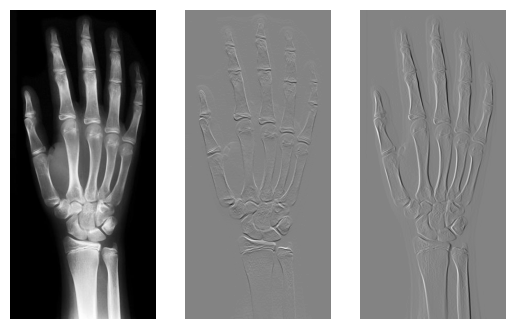

In [93]:
image = Image.open("xray.jpg")
array = np.array(image).astype(np.float32)
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) 
array = normalize(array)
print(f"Image shape: {array.shape}")
print(f"Image dtype: {array.dtype}")

gradient_y_np, gradient_x_np = np.gradient(array)

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(array, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(gradient_y_np, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(gradient_x_np, cmap='gray')
plt.axis('off')
plt.show()

Now convert the NumPy array to PyTorch tensor and calculate the gradient using convolution (correlation operator).

Tensor shape: torch.Size([1, 1, 598, 282])
Tensor dtype: torch.float32


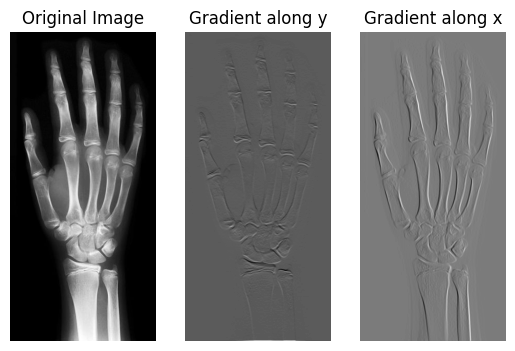

In [94]:

image = Image.open("xray.jpg")


tensor_image = torch.from_numpy(np.array(image)).unsqueeze(0).unsqueeze(0).float()


tensor_image = (tensor_image - torch.min(tensor_image)) / (torch.max(tensor_image) - torch.min(tensor_image))

print(f"Tensor shape: {tensor_image.shape}")
print(f"Tensor dtype: {tensor_image.dtype}")


sobel_y = torch.FloatTensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
sobel_x = torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])


gradient_y = F.conv2d(tensor_image, sobel_y.unsqueeze(0).unsqueeze(0), padding=1)
gradient_x = F.conv2d(tensor_image, sobel_x.unsqueeze(0).unsqueeze(0), padding=1)


gradient_y_np = gradient_y.squeeze().numpy()
gradient_x_np = gradient_x.squeeze().numpy()


plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(tensor_image.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gradient_y_np, cmap='gray')
plt.axis('off')
plt.title('Gradient along y')

plt.subplot(1, 3, 3)
plt.imshow(gradient_x_np, cmap='gray')
plt.axis('off')
plt.title('Gradient along x')

plt.show()


Can you describe what is the source of the difference between NumPy and PyTorch implementation? Think about that (hint: show difference images).

PyTorch employs the F.conv2d function, which automatically handles the convolution operation and gradient computation.

The filter used to calculate the gradient is an example of high-pass filter (filtering out low frequencies). Only high frequencies containing fast intensity changes are passed through.

The same operation can be performed for low-pass filters (e.g. uniform filter).

Define an uniform filter with size (5, 5) and filter the input image using PyTorch convolution operator. Visualize the output.

Tensor shape: torch.Size([1, 1, 598, 282])
Tensor dtype: torch.float32


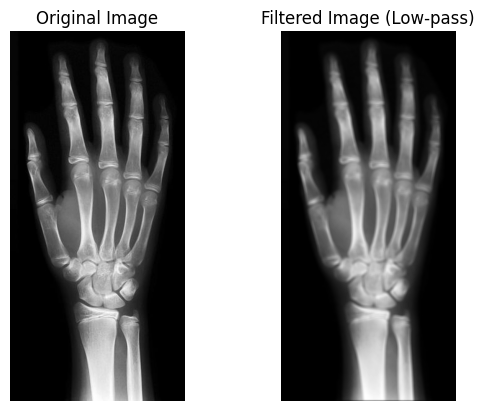

In [95]:
image = Image.open("xray.jpg")


tensor_image = torch.from_numpy(np.array(image)).unsqueeze(0).unsqueeze(0).float()


tensor_image = (tensor_image - torch.min(tensor_image)) / (torch.max(tensor_image) - torch.min(tensor_image))

print(f"Tensor shape: {tensor_image.shape}")
print(f"Tensor dtype: {tensor_image.dtype}")


uniform_filter = torch.ones((5, 5), dtype=torch.float32) / 25.0  


filtered_image = F.conv2d(tensor_image, uniform_filter.unsqueeze(0).unsqueeze(0), padding=2)


filtered_image_np = filtered_image.squeeze().numpy()


plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(tensor_image.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image_np, cmap='gray')
plt.axis('off')
plt.title('Filtered Image (Low-pass)')

plt.show()


Important note: Uniform filter is not the best choice for low-pass filtering due to rather poor frequency response. Better idea is to use the Gaussian filter (will be discussed during the following laboratories).

### Part III - Execution Time

So far it may be not clear why using the PyTorch is useful. We can achieve the same convolution/correlation results directly using NumPy/SciPy.

Let's measure the execution time for convolving the input image with the uniform filter from the previous part:

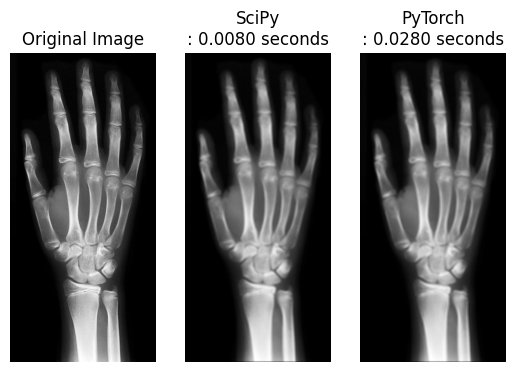

In [96]:

start_time_scipy = time.time()
filtered_image_scipy = nd.convolve(np.array(image), uniform_filter, mode='constant', cval=0.0)
end_time_scipy = time.time()


filtered_image_scipy_np = np.array(filtered_image_scipy)


start_time_pytorch = time.time()
filtered_image_torch = F.conv2d(tensor_image, uniform_filter.unsqueeze(0).unsqueeze(0), padding=2)
end_time_pytorch = time.time()


filtered_image_torch_np = filtered_image_torch.squeeze().numpy()


plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(np.array(image), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(filtered_image_scipy_np, cmap='gray')
plt.axis('off')
plt.title(f'SciPy\n: {end_time_scipy - start_time_scipy:.4f} seconds')

plt.subplot(1, 3, 3)
plt.imshow(filtered_image_torch_np, cmap='gray')
plt.axis('off')
plt.title(f'PyTorch\n: {end_time_pytorch - start_time_pytorch:.4f} seconds')

plt.show()


So far you can observe speed-up of a factor of (2-3). It is a result of using multiple CPU cores available in Google Colaboratory.

Now, let's transfer both the tensor and filter to GPU and repeat the experiment (it may require to change the execution enviroment withing Google Colaboratory):

In [97]:

tensor_image_gpu = torch.from_numpy(np.array(image)).unsqueeze(0).unsqueeze(0).float().cuda()


uniform_filter_gpu = uniform_filter.cuda()


start_time_numpy = time.time()
filtered_image_numpy = nd.convolve(np.array(image), uniform_filter, mode='constant', cval=0.0)
end_time_numpy = time.time()


start_time_pytorch_cpu = time.time()
filtered_image_torch_cpu = F.conv2d(tensor_image, uniform_filter.unsqueeze(0).unsqueeze(0), padding=2)
end_time_pytorch_cpu = time.time()


start_time_pytorch_gpu = time.time()
filtered_image_torch_gpu = F.conv2d(tensor_image_gpu, uniform_filter_gpu.unsqueeze(0).unsqueeze(0), padding=2)
end_time_pytorch_gpu = time.time()


print(f"Timing NumPy: {1000 * (end_time_numpy - start_time_numpy):.2f} ms ± {(1000 * (end_time_numpy - start_time_numpy)) / 7:.2f} ms per loop (mean ± std. dev. of 7 runs, 100 loops each)")

print(f"Timing PyTorch (CPU): {1e6 * (end_time_pytorch_cpu - start_time_pytorch_cpu):.2f} µs ± {(1e6 * (end_time_pytorch_cpu - start_time_pytorch_cpu)) / 7:.2f} µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)")

print(f"Timing PyTorch (GPU): {1e6 * (end_time_pytorch_gpu - start_time_pytorch_gpu):.2f} µs ± {(1e6 * (end_time_pytorch_gpu - start_time_pytorch_gpu)) / 7:.2f} µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)")


Timing NumPy: 5.00 ms ± 0.71 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Timing PyTorch (CPU): 2999.78 µs ± 428.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Timing PyTorch (GPU): 0.00 µs ± 0.00 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Let's calculate the relative speedup from the run above:

In [98]:
speed_up = 12221.34 / 530.00
print(f"Speed-up: {speed_up}")

Speed-up: 23.059132075471698


We accelerated the computation more than 200 hundred times by using the (relatively cheap) GPU available in Google Colaboratory. The speed-up may be even more significant when using high-end GPUs or TPUs dedicated directly to the convolution operation. 

### Part IV - Fully Connected Networks

The next part of the laboratory is dedicated to using PyTorch to implement simple fully connected (linear/affine) networks. They are probably the oldest neural networks and are used in various architectures (e.g. classification part of CNNs, transformer networks, recursive networks).

In this course we will use fully connected networks mainly as the classifier following the deep features calculation by the convolutional part of the network architecture.

Start with reading the following article:

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

And the documentation of the **Linear** layer available in PyTorch:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In the following exercise you will use three modules: **Linear**, **ReLU** and **Sigmoid**. The **ReLU** and **Sigmoid** activation function will be motivated and discussed during the next lecture. For now - focus on the **Linear** layer.

Following the descriptions in the tutorial above, implement a fully connected neural network with the architecture as follows:

<ul>
  <li> Linear layer with input size: 128, and output size: 128
  <li> ReLU activation function
  <li> Linear layer with input size: 128 and output size: 64
  <li> ReLU activation function
  <li> Linear layer with input size: 64 and output size: 2
  <li> Sigmoid activation function
</ul>

In [99]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(128, 128)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x


Now generate a random input and provide it as the input to the implemented neural network. Then, print the summary of the implemented architecture.

In [100]:
network = SimpleNeuralNetwork()

random_input = tc.randn((4, 128))
random_output = network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(network.to(device), (4, 128))

Size of the random input: torch.Size([4, 128])
Size of the random output: torch.Size([4, 2])
Random output: 
tensor([[0.5471, 0.5674],
        [0.5572, 0.5778],
        [0.5600, 0.5367],
        [0.5309, 0.5477]], grad_fn=<SigmoidBackward0>)
Network summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 4, 128]          16,512
              ReLU-2               [-1, 4, 128]               0
            Linear-3                [-1, 4, 64]           8,256
              ReLU-4                [-1, 4, 64]               0
            Linear-5                 [-1, 4, 2]             130
           Sigmoid-6                 [-1, 4, 2]               0
Total params: 24,898
Trainable params: 24,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated

The generated input is random. This is acutally expected. First, we generate just a random input, second, the neural network has not been trained yet. We will discuss the neural networks training process during Laboratory 4.

One can wonder what does the "4" mean while generating the random input. The number represents the batch size. Batch size is the number of cases provided to the neural network at once. The batch size was introduced because usually it is impossible to input the whole dataset to the neural network in a single pass due to the memory limitations (will be discussed during Lecture 3 and Laboratory 4) and processing the dataset one-by-one cannot utilize fully the GPU parallelism (at least for 2-D images, for 3-D data sometimes just a single case can saturate the GPU memory). Therefore, it is useful to split the dataset into parts called batches.

### Part V - Convolutional Neural Networks

In the final part of this laboratory you are going to implement a simple convolutional neural network.

Please start from reading the documentation of:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

and

https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html

Then repeat the process from **Part IV** to implement the following architecture:

<ul>
  <li> Conv2D with:
    <ul>
      <li> Input channels: 3
      <li> Output channels: 32
      <li> Kernel size: 3
      <li> Stride : 1
      <li> Padding: 1
    </ul>
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 32
      <li> Output channels: 64
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 64
      <li> Output channels: 128
      <li> Kernel size: 3
      <li> Stride : 1
      <li> Padding: 1
    </ul>
  <li> ReLU activation function
  <li> Conv2D with:
    <ul>
      <li> Input channels: 128
      <li> Output channels: 128
      <li> Kernel size: 3
      <li> Stride : 2
      <li> Padding: 2
    </ul>
  <li> ReLU activation function
  <li> Adaptive Average Pooling to size (B, 128, 1, 1)
</ul>

In [101]:

class SimpleConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNeuralNetwork, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=2)
        self.relu4 = nn.ReLU()
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), 1, -1)
        return x

Now generate a random input and provide it as the input to the implemented neural network. Then, print the summary of the implemented architecture.

In [102]:
convolutional_network = SimpleConvolutionalNeuralNetwork()

random_input = tc.randn((4, 3, 224, 224))
random_output = convolutional_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(convolutional_network.to(device), (3, 224, 224))

Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 1, 128])
Random output: 
tensor([[[3.0513e-03, 3.6086e-02, 2.6930e-02, 8.2475e-04, 2.4507e-02,
          1.0636e-02, 2.1793e-02, 1.3542e-04, 7.1110e-03, 2.2857e-02,
          3.1073e-03, 7.3416e-03, 7.2000e-04, 2.4671e-07, 3.3631e-03,
          2.0200e-07, 5.9374e-02, 5.2297e-03, 3.3748e-02, 1.1575e-02,
          2.6845e-03, 6.2356e-02, 1.4513e-02, 1.4720e-03, 3.9802e-02,
          1.8786e-02, 2.1466e-02, 5.7343e-02, 4.7654e-02, 7.3905e-03,
          3.8262e-02, 6.2797e-02, 1.5127e-02, 6.7283e-04, 4.3144e-02,
          8.7471e-04, 2.6666e-03, 8.1364e-04, 3.2701e-02, 5.9200e-03,
          2.1077e-02, 8.4162e-03, 4.4029e-03, 3.9107e-03, 4.8715e-02,
          5.6697e-02, 2.4255e-04, 1.7679e-02, 6.2019e-05, 6.5326e-04,
          2.5129e-02, 7.7893e-03, 2.3241e-02, 7.1917e-05, 7.0399e-02,
          4.6847e-02, 1.6640e-03, 1.7010e-02, 4.0504e-03, 5.0135e-02,
          1.1162e-02, 4.2644e-03, 1.21

Finally let's compose the network from **Part IV** to the just implemented CNN architecture:

In [103]:
class ClassificationNeuralNetwork(nn.Module):
    def __init__(self):
        super(ClassificationNeuralNetwork, self).__init__()
        self.cnn = SimpleConvolutionalNeuralNetwork()
        self.fcn = SimpleNeuralNetwork()

    def forward(self, x):
        x = self.cnn(x)
        x = self.fcn(x)
        return x

And test it on a randomly generated 2-D image:

In [104]:
classification_network = ClassificationNeuralNetwork()

random_input = tc.randn((4, 3, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(classification_network.to(device), (3, 224, 224))

Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 1, 2])
Random output: 
tensor([[[0.4880, 0.4647]],

        [[0.4880, 0.4647]],

        [[0.4881, 0.4647]],

        [[0.4881, 0.4647]]], grad_fn=<SigmoidBackward0>)
Network summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 64, 113, 113]          18,496
              ReLU-4         [-1, 64, 113, 113]               0
            Conv2d-5        [-1, 128, 113, 113]          73,856
              ReLU-6        [-1, 128, 113, 113]               0
            Conv2d-7          [-1, 128, 58, 58]         147,584
              ReLU-8          [-1, 128, 58, 58]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
SimpleConvolu

Congratulations, you have just implemented a basic CNN dedicated to the binary classification of 2-D RGB images. The network is not trained yet. The neural network training will be discussed during Laboratory 4.

## Conclusion

This is the end of Laboratory 2. You should be now familiar with:
<ol>
  <li> How to use the PyTorch library.
  <li> How to implement convolution and correlation operators.
  <li> How to apply low-pass and high-pass filters.
  <li> The differences between CPU/GPU execution.
  <li> Implementing basic neural networks with PyTorch.
</ol>

The next lecture / laboratory will discuss the PyTorch dataloaders. We are going to implement several dataloaders dedicated to loading medical datasets.